# Mall Customers Kaggle Dataset. Unsupervised Learning. 

### ref: https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from IPython.display import display
from sklearn.compose import ColumnTransformer

%matplotlib inline

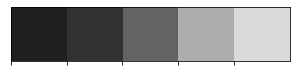

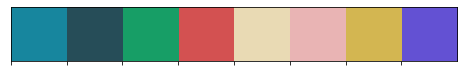

In [160]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_mix = ["#17869E", '#264D58', '#179E66', '#D35151', '#E9DAB4', '#E9B4B4', '#D3B651', '#6351D3']

sns.palplot(colors_dark)
sns.palplot(colors_mix)

In [64]:
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");


def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute
    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax
    

def channel_results(reduced_data, outliers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
	Data is labeled by "Channel" and cues added for student-selected sample data
	'''

	# Check that the dataset is loadable
	try:
	    full_data = pd.read_csv("customers.csv")
	except:
	    print("Dataset could not be loaded. Is the file missing?")       
	    return False

	# Create the Channel DataFrame
	channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
	channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
	labeled = pd.concat([reduced_data, channel], axis = 1)
	
	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned Channel
	labels = ['Hotel/Restaurant/Cafe', 'Retailer']
	grouped = labeled.groupby('Channel')
	for i, channel in grouped:   
	    channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);
	    
	# Plot transformed sample points   
	for i, sample in enumerate(pca_samples):
		ax.scatter(x = sample[0], y = sample[1], \
	           s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none');
		ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125);

	# Set plot title
	ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");

In [20]:
#download the dataset
cus = pd.read_csv('Mall_Customers.csv', sep=',')
print("Shape of the dataset:{}".format(cus.shape))
cus = cus.drop('CustomerID', axis =1)
cus

Shape of the dataset:(200, 5)


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


In [21]:
cus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [22]:
cus.isnull().any()

Gender                    False
Age                       False
Annual Income (k$)        False
Spending Score (1-100)    False
dtype: bool

In [23]:
cus.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


<AxesSubplot:>

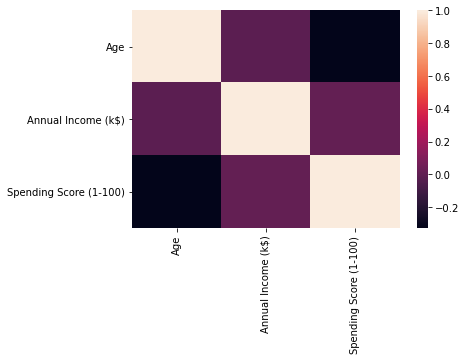

In [24]:
sns.heatmap(cus.corr())

#### We can observe from the correlation plot that:
#### 1. age is heavily negatively correlated to spending score.
#### 2. annual income -  age & annual income - spending score are also  negatively correlated.

<AxesSubplot:>

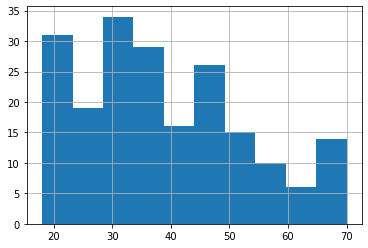

In [26]:
#Age distribution
cus.Age.hist()

<AxesSubplot:>

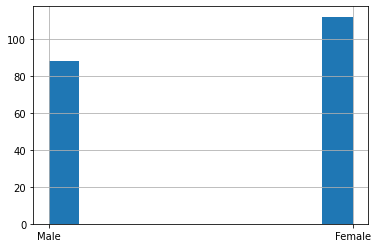

In [27]:
#Gender distribution
cus.Gender.hist()

Text(0.5, 1.0, 'Age distribution wrt to Gender')

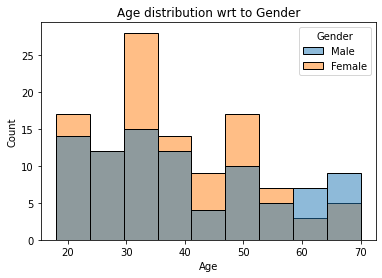

In [29]:
#Age distribution wrt to Gender
sns.histplot(cus, x='Age' ,hue='Gender')
plt.title("Age distribution wrt to Gender")

Text(0.5, 1.0, 'Age vs Annual Income distribution wrt to Gender')

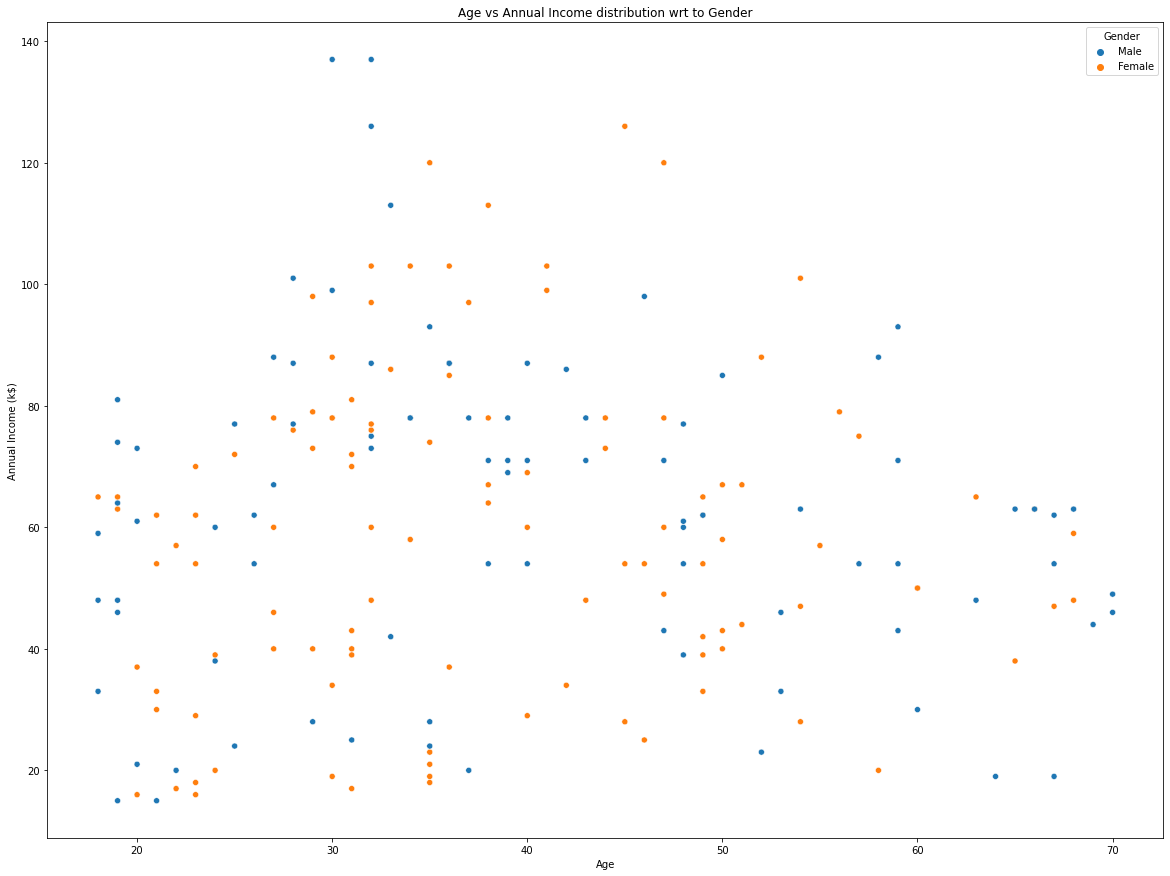

In [43]:
#Age vs Annual Income distribution wrt to Gender
a4_dims = (20, 15)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='Age', y="Annual Income (k$)" ,ax = ax,data = cus, hue='Gender')
# plt.figure(figsize=(20,15))
plt.title("Age vs Annual Income distribution wrt to Gender")

Text(0.5, 1.0, 'Spending Score vs Annual Income')

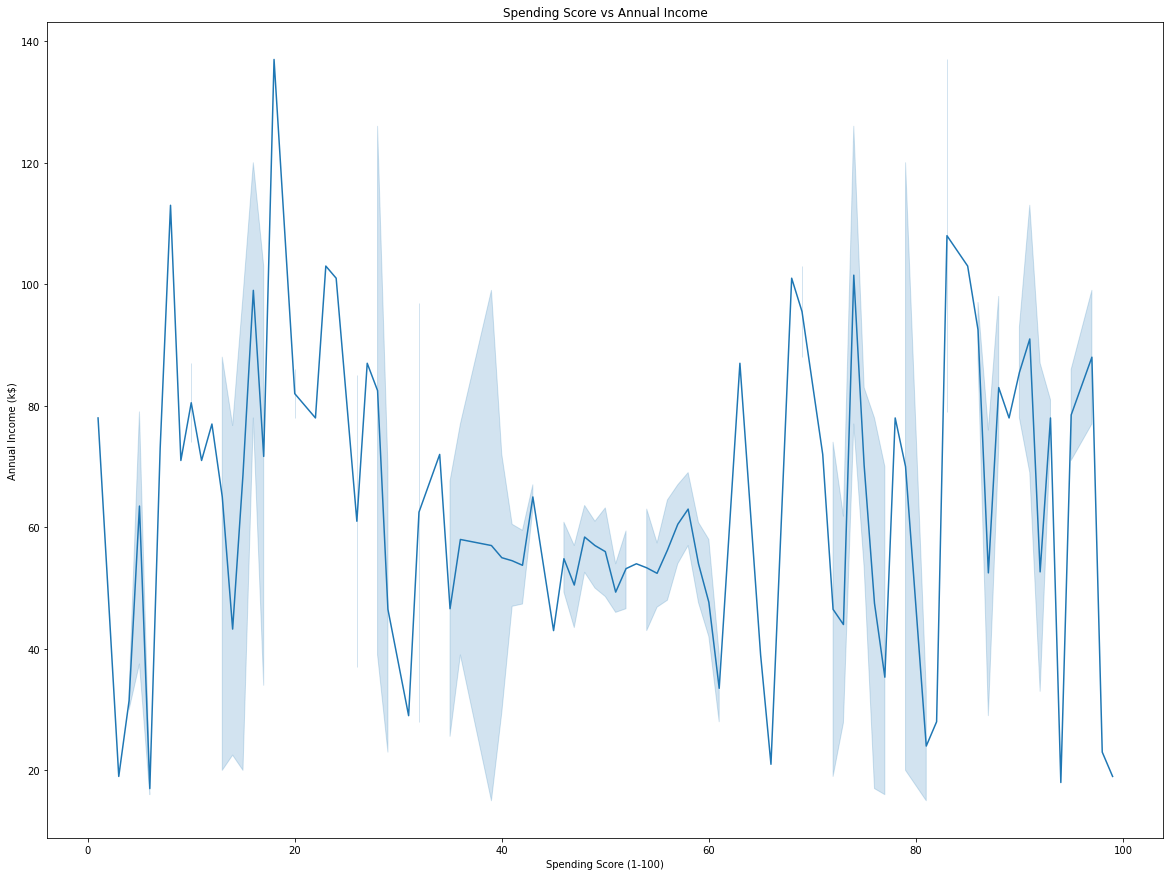

In [49]:
#Spending Score vs Annual Income
a4_dims = (20, 15)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(x='Spending Score (1-100)', y="Annual Income (k$)" ,ax = ax,data = cus)
# plt.figure(figsize=(20,15))
plt.title("Spending Score vs Annual Income")

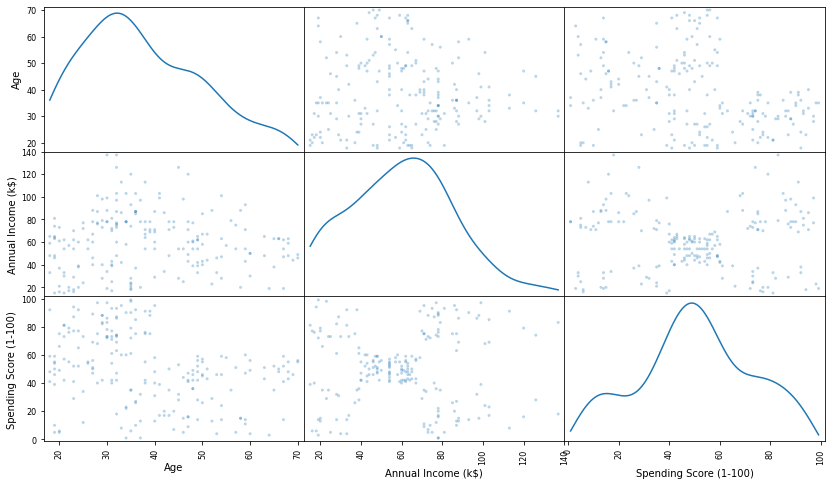

In [52]:
scatter_matrix(cus, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

#### Label encoding of categorical variable

In [56]:
cus['Gender'] = cus['Gender'].apply(lambda x: 1 if x=='Male' else 2)
cus

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,2,20,16,6
3,2,23,16,77
4,2,31,17,40
...,...,...,...,...
195,2,35,120,79
196,2,45,126,28
197,1,32,126,74
198,1,32,137,18


### Outlier Detection

In [63]:
outliers = []

for feature in cus.keys():
    q1 = np.percentile(cus[feature].astype(int),25)
    q3 = np.percentile(cus[feature].astype(int),75)
    
    step = 1.5 * (q3 - q1) #interquartile distance
    print("Outliers of: {}".format(feature))
    display(cus[~((cus[feature] >= q1-step) & (cus[feature] <= q3+step))])
    out_indexes = cus[~((cus[feature] >= q1-step) & (cus[feature] <= q3+step))].index.tolist()
    outliers.append(out_indexes)

Outliers of: Gender


,Gender,Age,Annual Income (k$),Spending Score (1-100)


Outliers of: Age


,Gender,Age,Annual Income (k$),Spending Score (1-100)


Outliers of: Annual Income (k$)


,Gender,Age,Annual Income (k$),Spending Score (1-100)
198,1,32,137,18
199,1,30,137,83


Outliers of: Spending Score (1-100)


,Gender,Age,Annual Income (k$),Spending Score (1-100)


#### No common outliers. So we will be taking the whole dataset

### Feature Scaling

In [219]:
sc = StandardScaler()
sc.fit(cus.sample(frac=0.2).reset_index(drop=True))
cus_scaled = cus.copy()
print('Before Scaling')
display(cus_scaled)
cus_scaled = sc.transform(cus_scaled)
cus_scaled = pd.DataFrame(cus_scaled,columns=cus.keys())
print('After Scaling')
cus_scaled

Before Scaling


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,2,20,16,6
3,2,23,16,77
4,2,31,17,40
...,...,...,...,...
195,2,35,120,79
196,2,45,126,28
197,1,32,126,74
198,1,32,137,18


After Scaling


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,-1.224745,-1.489993,-1.990298,-0.646332
1,-1.224745,-1.341180,-1.990298,1.066346
2,0.816497,-1.415587,-1.952674,-1.992008
3,0.816497,-1.192367,-1.952674,0.903234
4,0.816497,-0.597113,-1.915050,-0.605554
...,...,...,...,...
195,0.816497,-0.299487,1.960199,0.984790
196,0.816497,0.444580,2.185941,-1.094891
197,-1.224745,-0.522707,2.185941,0.780900
198,-1.224745,-0.522707,2.599803,-1.502671


### PCA on scaled data

,Explained Variance,Gender,Age,Annual Income (k$),Spending Score (1-100)
Dimension 1,0.3247,0.2856,-0.6420,-0.2725,0.6573
Dimension 2,0.2627,-0.9072,0.0117,0.0330,0.4192
Dimension 3,0.2477,0.0960,-0.2231,0.9601,0.1384
Dimension 4,0.1648,-0.2936,-0.7334,-0.0530,-0.6108


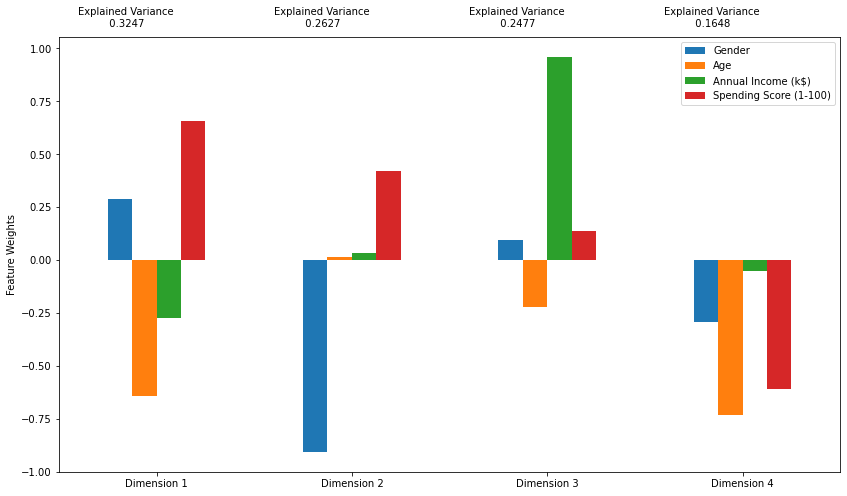

In [220]:
pca = PCA(n_components=cus_scaled.shape[1], random_state = 42)
cus_samp = cus_scaled.sample(frac=0.2).reset_index(drop=True)
pca.fit(cus_samp)
pca_res = pca.transform(cus_scaled)
pca_results(cus_scaled, pca)

,Explained Variance,Gender,Age,Annual Income (k$),Spending Score (1-100)
Dimension 1,0.3873,-0.4054,0.5819,-0.2642,-0.6536
Dimension 2,0.2605,-0.5106,0.1310,0.8448,0.0919
Dimension 3,0.1951,0.5706,-0.1581,0.4426,-0.6735


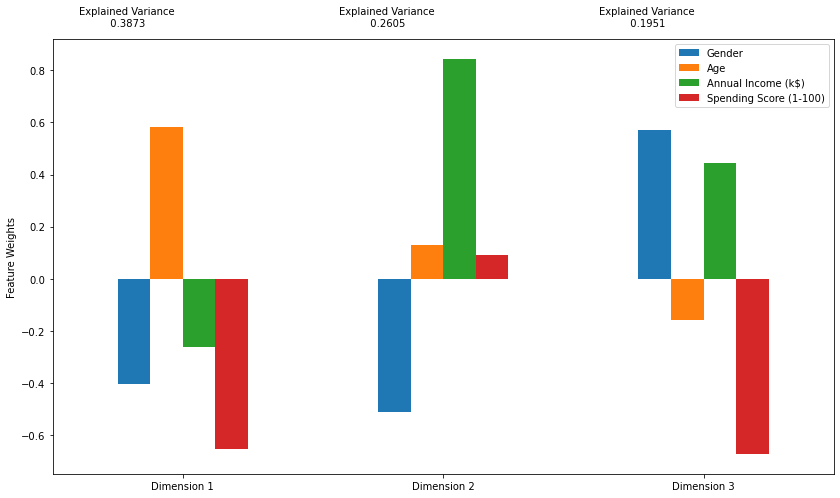

In [221]:
#Taking the first three components

pca = PCA(n_components=3)
cus_samp = cus_scaled.sample(frac=0.2).reset_index(drop=True)
pca.fit(cus_samp)
pca_res = pca.transform(cus_scaled)
pca_results(cus_scaled, pca)

In [222]:
reduced_data = pd.DataFrame(pca_res, columns=['Dimension 1','Dimension 2','Dimension 3'])
reduced_data

,Dimension 1,Dimension 2,Dimension 3
0,0.225780,-1.379093,-0.796267
1,-0.807078,-1.202219,-1.973220
2,0.311296,-2.503511,1.279527
3,-1.451222,-2.208225,-0.705604
4,-0.128563,-2.237084,0.233075
...,...,...,...
195,-2.018617,1.221782,0.830315
196,-0.285900,1.318883,2.213217
197,-1.247466,2.406802,-0.061800
198,0.135814,2.546592,1.659297


<AxesSubplot:title={'center':'PC plane with original feature projections.'}, xlabel='Dimension 1', ylabel='Dimension 2'>

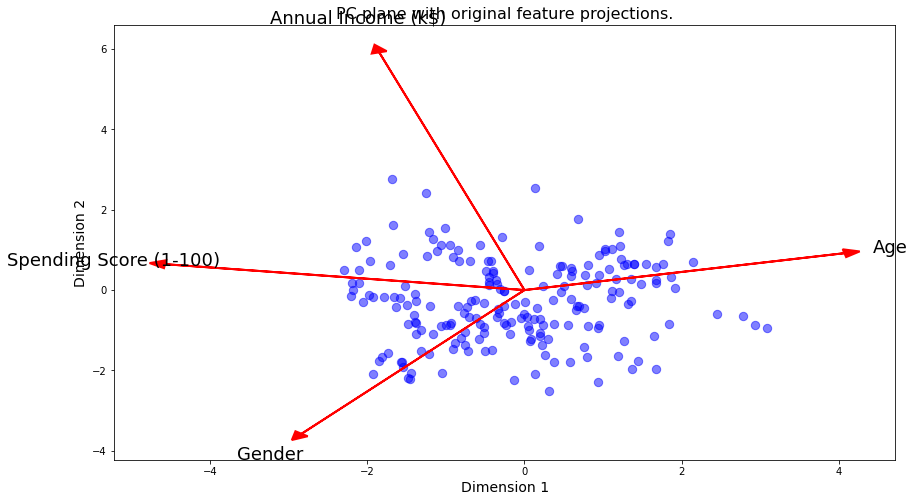

In [223]:
#create biplot

biplot(cus_scaled, reduced_data, pca)

### Clustering on Scaled Data

In [224]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

scores = {}
for i in range(2,7):
    
    print('Number of clusters: ' + str(i))
        
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(random_state=42, n_components=i)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_
    print('Cluster Center: ' + str(centers))

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(reduced_data)
    print('Sample predictions: ' + str(sample_preds))

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    scores[i] = score
    print('Silhouette score is: ' + str(score), '\n')
    
print('Scores: ' + str(scores))

Number of clusters: 2
Cluster Center: [[-1.30083298 -0.16346596 -0.51212027]
 [ 0.49370272 -0.34078583  0.38520129]]
Sample predictions: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
Silhouette score is: 0.2772756855296202 

Number of clusters: 3
Cluster Center: [[-1.15965722  0.05370194 -0.6683893 ]
 [-0.28023032 -0.95772525  0.63499991]
 [ 1.14462739  0.31425841  0.0651818 ]]
Sample predictions: [1 0 1 0 1 0 1 0 2 1 2 0 1 0 2 0 1 0 2 0 2 0 1 0 1 0 1 0 1 0 2 1 2 0 1 0 1
 1 1 1 1 0 2 1 1 1 1 1 1 1 1 0 1 2 1 2 1 2 1 2 2 0 2 1 2 0 1 2 0 1 2 1 1 1
 2 0 1 2 1 1 2 2 2 1 1 2 1 1 1 1 2 0 2 1 1 0 1 1 2 0 1 1 2 0 2 1 2 2 2 2 2
 1 1 0 1 1 2 

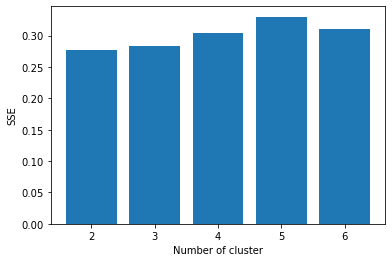

In [225]:
plt.bar(list(scores.keys()), list(scores.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [226]:
# Apply your clustering algorithm of choice to the reduced data 
clusterer = GaussianMixture(random_state=42, n_components=4)
clusterer.fit(reduced_data)

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.means_
print('Cluster Center: ' + str(centers))

# Predict the cluster for each transformed sample data point
samp = reduced_data.sample(frac = 0.01).reset_index(drop=True)
sample_preds = clusterer.predict(samp)
print('Sample predictions: ' + str(sample_preds))

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
scores[i] = score
print('Silhouette score is: ' + str(score), '\n')

Cluster Center: [[-0.73267117  0.34758762 -1.03242817]
 [ 0.22853107 -0.73261527  0.81269114]
 [ 1.39566778  0.42809559 -0.20327298]
 [-1.54839643 -0.74392738  0.11186525]]
Sample predictions: [2 0]
Silhouette score is: 0.3046227900531786 



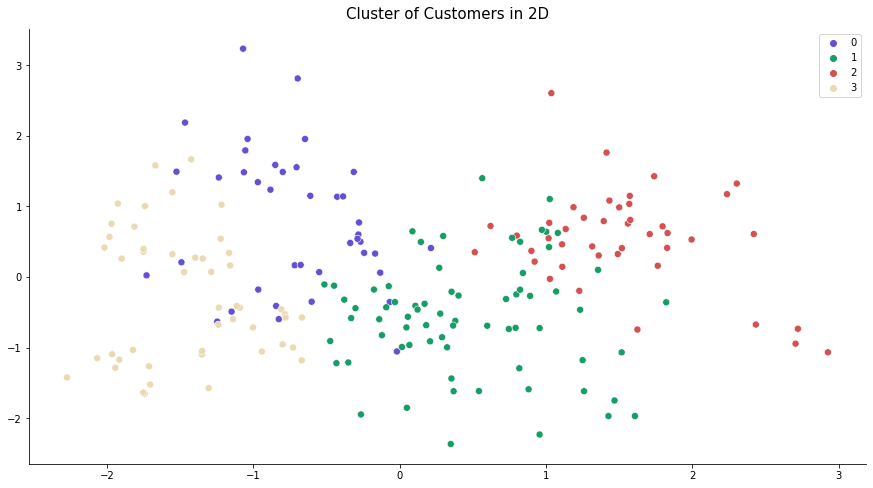

In [229]:
pca = PCA(2)
pca.fit(reduced_data)
X_PCA = pca.transform(reduced_data)
plt.figure(figsize=(15,8))
sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1], 
                hue=preds, palette=[colors_mix[7],colors_mix[2],colors_mix[3],colors_mix[4]], s=50)
plt.title('Cluster of Customers in 2D', size=15, pad=10)
sns.despine()
plt.legend(loc=0, bbox_to_anchor=[1,1])
plt.show()

In [230]:
# pca = PCA(3)
# pca.fit(reduced_data)
# X_PCA = pca.transform(reduced_data)

X_PCA = reduced_data.copy()
fig = px.scatter_3d(x=X_PCA.iloc[:,0].values, y=X_PCA.iloc[:,1].values, z=X_PCA.iloc[:,2].values,
                    color=preds,opacity=0.8,color_continuous_scale=[colors_mix[7],colors_mix[2],colors_mix[3],colors_mix[4]],
                   width=800,height=800)

fig.update_layout(font_family='monospace',
    title=dict(text='Customer Clusters in 3D',x=0.5,y=0.95,
    font=dict(color=colors_dark[2],size=20)),
    coloraxis_showscale=False)
fig.show()

### PCA on Unscaled Data

#### Note: The data used below will be unscaled. But the df name will remain same i.e cus_scaled. 

In [193]:
cus_scaled = cus.copy()

,Explained Variance,Gender,Age,Annual Income (k$),Spending Score (1-100)
Dimension 1,0.5271,-0.0050,-0.0925,0.9951,0.0351
Dimension 2,0.3777,0.0008,0.2967,0.0612,-0.9530
Dimension 3,0.0951,-0.0038,0.9505,0.0777,0.3009
Dimension 4,0.0001,-1.0000,-0.0030,-0.0053,-0.0021


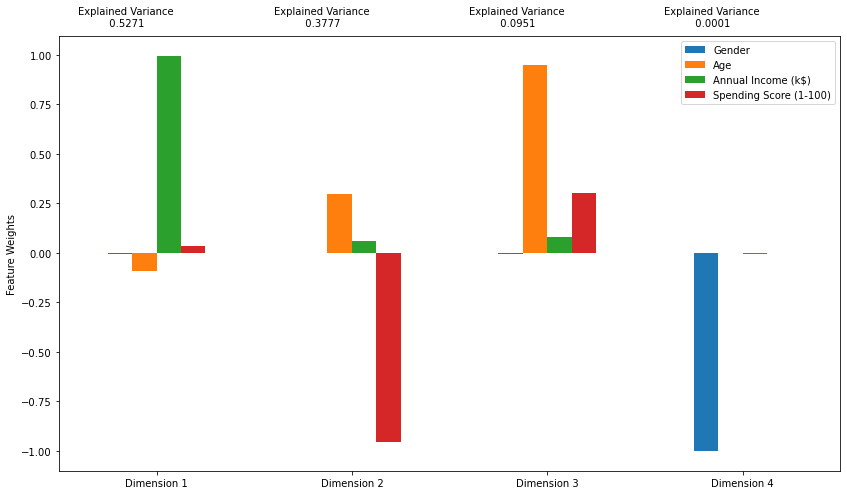

In [194]:
pca = PCA(n_components=cus_scaled.shape[1], random_state = 42)
cus_samp = cus_scaled.sample(frac=0.2).reset_index(drop=True)
pca.fit(cus_samp)
pca_res = pca.transform(cus_scaled)
pca_results(cus_scaled, pca)

,Explained Variance,Gender,Age,Annual Income (k$),Spending Score (1-100)
Dimension 1,0.5072,-0.0035,0.1175,0.7029,-0.7015
Dimension 2,0.3681,-0.0004,0.1237,-0.7113,-0.6920


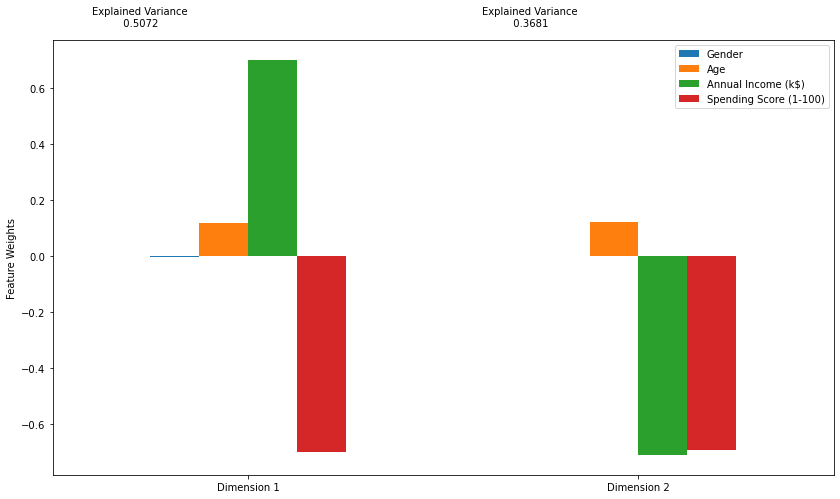

In [195]:
#Taking the first three components

pca = PCA(n_components=2)
cus_samp = cus_scaled.sample(frac=0.2).reset_index(drop=True)
pca.fit(cus_samp)
pca_res = pca.transform(cus_scaled)
pca_results(cus_scaled, pca)

In [196]:
reduced_data = pd.DataFrame(pca_res, columns=['Dimension 1','Dimension 2'])
reduced_data

,Dimension 1,Dimension 2
0,-36.411591,39.943135
1,-65.639906,11.127844
2,-12.445005,62.190101
3,-61.899526,13.431425
4,-34.301123,39.312286
...,...,...
195,11.209386,-60.439337
196,52.378350,-28.179892
197,18.585435,-61.617686
198,65.601748,-30.691357


<AxesSubplot:title={'center':'PC plane with original feature projections.'}, xlabel='Dimension 1', ylabel='Dimension 2'>

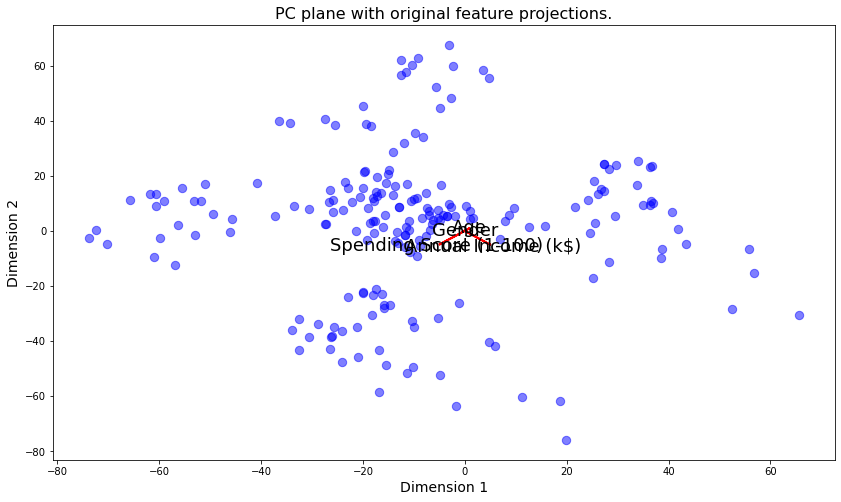

In [197]:
#create biplot

biplot(cus_scaled, reduced_data, pca)

### Clustering on Unscaled Data

In [198]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

scores = {}
for i in range(2,7):
    
    print('Number of clusters: ' + str(i))
        
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(random_state=42, n_components=i)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_
    print('Cluster Center: ' + str(centers))

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(reduced_data)
    print('Sample predictions: ' + str(sample_preds))

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    scores[i] = score
    print('Silhouette score is: ' + str(score), '\n')
    
print('Scores: ' + str(scores))

Number of clusters: 2
Cluster Center: [[-27.13352401 -28.79369208]
 [ -4.65322963  11.7252303 ]]
Sample predictions: [1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1
 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
Silhouette score is: 0.38605047783641955 

Number of clusters: 3
Cluster Center: [[-18.05241288   6.57324292]
 [ 10.52924672  23.97905983]
 [-15.17491361 -38.6708436 ]]
Sample predictions: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 1 2 1 2 0 2 1 2 1 2 1 2 1 2

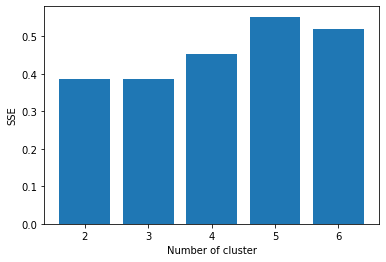

In [199]:
plt.bar(list(scores.keys()), list(scores.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [200]:
# Apply your clustering algorithm of choice to the reduced data 
clusterer = GaussianMixture(random_state=42, n_components=5)
clusterer.fit(reduced_data)

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.means_
print('Cluster Center: ' + str(centers))

# Predict the cluster for each transformed sample data point
samp = reduced_data.sample(frac = 0.01).reset_index(drop=True)
sample_preds = clusterer.predict(samp)
print('Sample predictions: ' + str(sample_preds))

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
scores[i] = score
print('Silhouette score is: ' + str(score), '\n')

Cluster Center: [[-57.07818216   5.0811535 ]
 [-12.22871967   6.89112053]
 [-14.91277939 -38.854959  ]
 [-12.90977485  47.17844723]
 [ 34.28563058   5.89794437]]
Sample predictions: [1 3]
Silhouette score is: 0.5521626379672798 



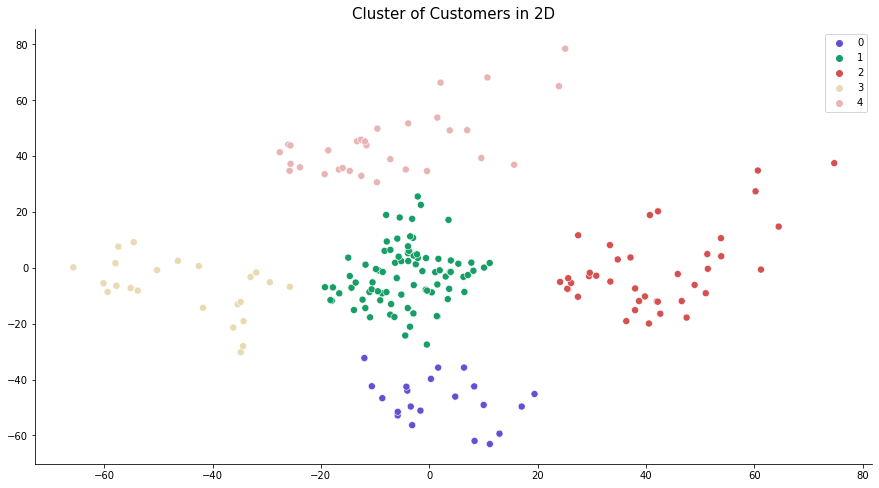

In [203]:
# pca = PCA(2)
# pca.fit(reduced_data)
# X_PCA = pca.transform(reduced_data)
X_PCA = reduced_data.copy()
plt.figure(figsize=(15,8))
sns.scatterplot(x=X_PCA.iloc[:, 0].values, y=X_PCA.iloc[:, 1].values, 
                hue=preds, palette=[colors_mix[7],colors_mix[2],colors_mix[3],colors_mix[4],colors_mix[5]], s=50)
plt.title('Cluster of Customers in 2D', size=15, pad=10)
sns.despine()
plt.legend(loc=0, bbox_to_anchor=[1,1])
plt.show()

## Clustering on Scaled Data WITHOUT PCA 

In [205]:
sc = StandardScaler()
sc.fit(cus.sample(frac=0.2).reset_index(drop=True))
reduced_data = cus.copy()
print('Before Scaling')
display(cus_scaled)
reduced_data = sc.transform(reduced_data)
reduced_data = pd.DataFrame(reduced_data,columns=cus.keys())
print('After Scaling')
cus_scaled

Before Scaling


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,2,20,16,6
3,2,23,16,77
4,2,31,17,40
...,...,...,...,...
195,2,35,120,79
196,2,45,126,28
197,1,32,126,74
198,1,32,137,18


After Scaling


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,2,20,16,6
3,2,23,16,77
4,2,31,17,40
...,...,...,...,...
195,2,35,120,79
196,2,45,126,28
197,1,32,126,74
198,1,32,137,18


In [206]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

scores = {}
for i in range(2,7):
    
    print('Number of clusters: ' + str(i))
        
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(random_state=42, n_components=i)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_
    print('Cluster Center: ' + str(centers))

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(reduced_data)
    print('Sample predictions: ' + str(sample_preds))

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    scores[i] = score
    print('Silhouette score is: ' + str(score), '\n')
    
print('Scores: ' + str(scores))

Number of clusters: 2
Cluster Center: [[ 0.02849319 -0.9189622  -0.15116158  0.86542475]
 [ 0.01331994  0.55331048 -0.18623935 -0.76720494]]
Sample predictions: [0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1
 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
Silhouette score is: 0.2619615867294685 

Number of clusters: 3
Cluster Center: [[-1.1055416  -0.778125    2.71711367  1.37165131]
 [ 0.90453403 -0.16184891 -0.22005126  0.01941088]
 [-1.1055416  -0.02324556 -0.14004644 -0.12717828]]
Sample predictions: [2 2 1 1 1 1 1 1 2 1 2 1 1 1 2 2 1 2 2 1 2 2 1 2 1 2 1 2 1 1 2 1 2 2 1 1 1
 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 2 1 2 1 2 1 2 2 2 1 1 2 2 1 1 2 1 2 1 1 1
 2 2 1 2 1 1 2 2 2 1 1 2 1 1

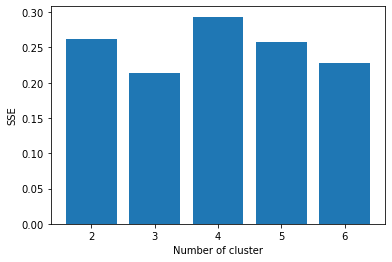

In [207]:
plt.bar(list(scores.keys()), list(scores.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [208]:
# Apply your clustering algorithm of choice to the reduced data 
clusterer = GaussianMixture(random_state=42, n_components=5)
clusterer.fit(reduced_data)

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)
clus_data = reduced_data.copy()
clus_data['clusters'] = preds
# Find the cluster centers
centers = clusterer.means_
print('Cluster Center: ' + str(centers))

# Predict the cluster for each transformed sample data point
samp = reduced_data.sample(frac = 0.01).reset_index(drop=True)
sample_preds = clusterer.predict(samp)
print('Sample predictions: ' + str(sample_preds))

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
scores[i] = score
print('Silhouette score is: ' + str(score), '\n')

Cluster Center: [[-1.1055416  -0.92392298 -0.10919148  0.89981877]
 [ 0.90453403  0.50350313 -0.27708193 -0.66037696]
 [-1.1055416   0.68156284 -0.10628903 -0.91778654]
 [ 0.90453403 -0.98709966 -0.48676377  0.55892447]
 [ 0.90453403 -0.64437642  0.98461242  1.55916797]]
Sample predictions: [0 0]
Silhouette score is: 0.2575377480250396 



In [209]:
clus_data

,Gender,Age,Annual Income (k$),Spending Score (1-100),clusters
0,-1.105542,-1.615228,-1.891685,-0.518800,0
1,-1.105542,-1.463027,-1.891685,1.285722,0
2,0.904534,-1.539127,-1.853908,-1.936638,1
3,0.904534,-1.310827,-1.853908,1.113862,3
4,0.904534,-0.702025,-1.816131,-0.475835,1
...,...,...,...,...,...
195,0.904534,-0.397624,2.074904,1.199792,4
196,0.904534,0.363379,2.301566,-0.991413,1
197,-1.105542,-0.625925,2.301566,0.984968,0
198,-1.105542,-0.625925,2.717114,-1.421061,2


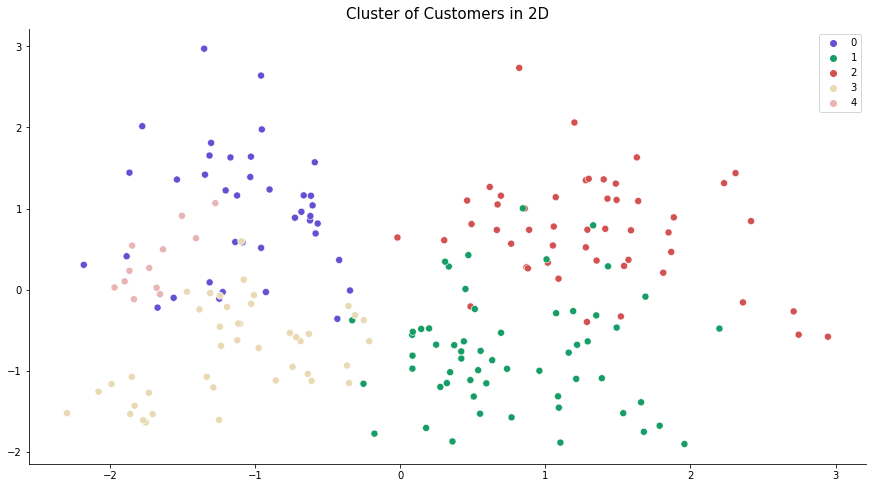

In [210]:
pca = PCA(2)
pca.fit(reduced_data)
X_PCA = pca.transform(reduced_data)
plt.figure(figsize=(15,8))
sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1], 
                hue=preds, palette=[colors_mix[7],colors_mix[2],colors_mix[3],colors_mix[4],colors_mix[5]], s=50)
plt.title('Cluster of Customers in 2D', size=15, pad=10)
sns.despine()
plt.legend(loc=0, bbox_to_anchor=[1,1])
plt.show()

In [211]:
pca = PCA(3)
pca.fit(reduced_data)
X_PCA = pca.transform(reduced_data)


fig = px.scatter_3d(x=X_PCA[:,0], y=X_PCA[:,1], z=X_PCA[:,2],
                    color=preds,opacity=0.8,color_continuous_scale=[colors_mix[7],colors_mix[2],colors_mix[3],colors_mix[4],colors_mix[5]],
                   width=800,height=800)

fig.update_layout(font_family='monospace',
    title=dict(text='Customer Clusters in 3D',x=0.5,y=0.95,
    font=dict(color=colors_dark[2],size=20)),
    coloraxis_showscale=False)
fig.show()

## Clustering on Unscaled Data WITHOUT PCA 

In [212]:
reduced_data = cus.copy()

In [213]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

scores = {}
for i in range(2,7):
    
    print('Number of clusters: ' + str(i))
        
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(random_state=42, n_components=i)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_
    print('Cluster Center: ' + str(centers))

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(reduced_data)
    print('Sample predictions: ' + str(sample_preds))

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    scores[i] = score
    print('Silhouette score is: ' + str(score), '\n')
    
print('Scores: ' + str(scores))

Number of clusters: 2
Cluster Center: [[ 1.54522894 28.15040161 61.64007271 72.77358011]
 [ 1.57078799 46.6644133  59.77117277 33.71346674]]
Sample predictions: [0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1
 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
Silhouette score is: 0.2900870022289252 

Number of clusters: 3
Cluster Center: [[ 1.59578118 40.36916283 46.95008324 48.57195626]
 [ 1.54513646 32.57764852 87.02197898 82.38078134]
 [ 1.40955137 39.84540227 90.55254874 15.81409349]]
Sample predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0

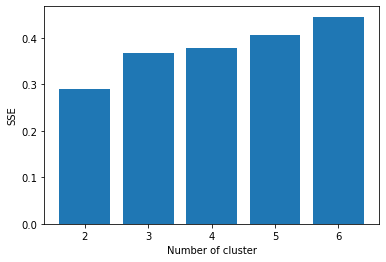

In [214]:
plt.bar(list(scores.keys()), list(scores.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [215]:
# Apply your clustering algorithm of choice to the reduced data 
clusterer = GaussianMixture(random_state=42, n_components=6)
clusterer.fit(reduced_data)

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)
clus_data = reduced_data.copy()
clus_data['clusters'] = preds
# Find the cluster centers
centers = clusterer.means_
print('Cluster Center: ' + str(centers))

# Predict the cluster for each transformed sample data point
samp = reduced_data.sample(frac = 0.01).reset_index(drop=True)
sample_preds = clusterer.predict(samp)
print('Sample predictions: ' + str(sample_preds))

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
scores[i] = score
print('Silhouette score is: ' + str(score), '\n')

Cluster Center: [[ 1.60750308 24.74416904 25.01378175 81.00958616]
 [ 1.61694782 24.69073384 54.19334845 50.57754269]
 [ 1.45182093 41.37190955 89.04692839 16.12238314]
 [ 1.5607527  53.05684446 55.74374505 48.71315461]
 [ 1.54220154 32.70436199 86.20798833 81.88853851]
 [ 1.62344551 44.91690858 26.43248359 21.28742451]]
Sample predictions: [3 5]
Silhouette score is: 0.44554665984545394 



In [216]:
clus_data

,Gender,Age,Annual Income (k$),Spending Score (1-100),clusters
0,1,19,15,39,5
1,1,21,15,81,0
2,2,20,16,6,5
3,2,23,16,77,0
4,2,31,17,40,5
...,...,...,...,...,...
195,2,35,120,79,4
196,2,45,126,28,2
197,1,32,126,74,4
198,1,32,137,18,2


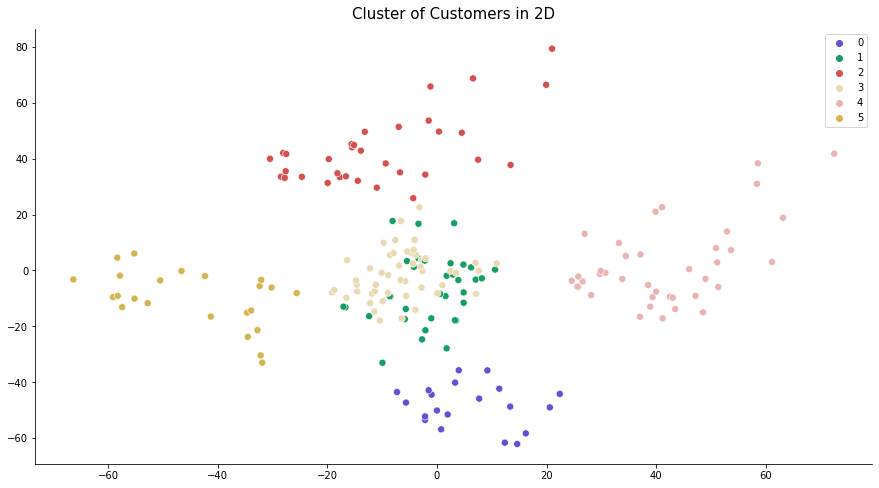

In [217]:
pca = PCA(2)
pca.fit(reduced_data)
X_PCA = pca.transform(reduced_data)
plt.figure(figsize=(15,8))
sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1], 
                hue=preds, palette=[colors_mix[7],colors_mix[2],colors_mix[3],colors_mix[4],colors_mix[5],colors_mix[6]], s=50)
plt.title('Cluster of Customers in 2D', size=15, pad=10)
sns.despine()
plt.legend(loc=0, bbox_to_anchor=[1,1])
plt.show()

In [218]:
pca = PCA(3)
pca.fit(reduced_data)
X_PCA = pca.transform(reduced_data)


fig = px.scatter_3d(x=X_PCA[:,0], y=X_PCA[:,1], z=X_PCA[:,2],
                    color=preds,opacity=0.8,color_continuous_scale=[colors_mix[7],colors_mix[2],colors_mix[3],colors_mix[4],colors_dark[3],colors_mix[5]],
                   width=800,height=800)

fig.update_layout(font_family='monospace',
    title=dict(text='Customer Clusters in 3D',x=0.5,y=0.95,
    font=dict(color=colors_dark[2],size=20)),
    coloraxis_showscale=False)
fig.show()